### Objetivo:
Executar um exemplo de envio de dados originários do Hive para o Kafka utilizando o Spark.
Tanto o envio quanto o recebimento é realizado em modo Bath.
#### Criação do Tópico no Kafka
Através da execução do Shell Script __*criar_topico.sh*__ o tópico __*topic-covid19spark*__ é criado e na sequência um Kafka-Consumer é criado/acionado para a checagem do recebimento das menssagens uriundas do Spark.

#### Comandos iniciais para
*docker exec -it kafka bash* - entrar no servidor Kafka otilizando o Docher - e */tmp/criar_topico.sh kafka:9092 topic-covid19spark* - execurar o Shell Script passando como parâmetros o servidor e o nome do tópico a ser criado.

In [ ]:
# Shell Script criar_topico.sh:
'''
#!/bin/sh

echo "[Inicio]"
SERVER=$1
TOPICO=$2

KAFKA="kafka-topics.sh --bootstrap-server $SERVER"

echo "[Criando o topico '$TOPICO' no Kafka...]"
$KAFKA --topic $TOPICO --create --partitions 1 --replication-factor 1

echo "[Listando os topicos existentes...]"
$KAFKA --list

echo "[Informacoes do topico '$TOPICO'...]"

$KAFKA --topic $TOPICO --describe

echo "[Criando o consumer do topico '$TOPICO' para checagem...]"
echo "[...Aguardando o envio...]"

kafka-console-consumer.sh --bootstrap-server $SERVER --topic $TOPICO
'''

### a) Criando o Tópico no Kafka e Consumidor para recebimento:

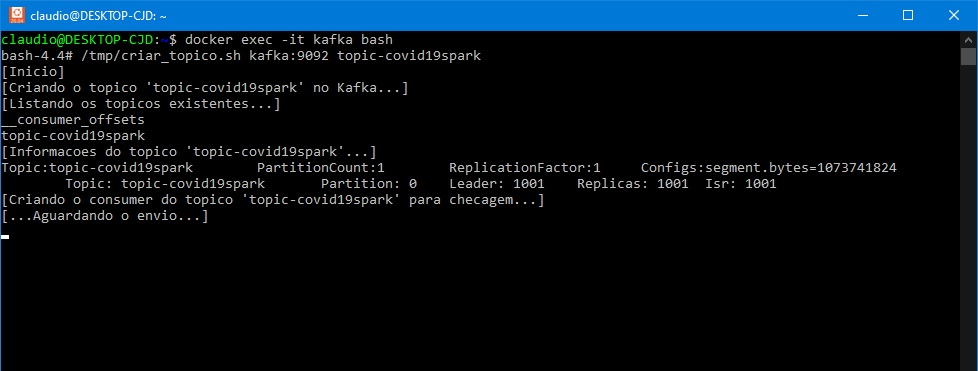

### b) Definição do Hive contest e conexão com o banco de dados:

In [9]:
from pyspark.sql.functions import col, lit, concat, split
from pyspark.sql import HiveContext
sql_context = HiveContext(sc)
spark.catalog.setCurrentDatabase("br_covid19_2020_2021")

### c) Selecionando alguns dados e o Schema da tabela Hive/Parquet para envio:

In [2]:
%%time
df = sql_context.sql("SELECT regiao, estado, casosAcumulado FROM covid19parquetsnappy \
                       WHERE regiao='Nordeste' AND municipio=''\
                    ORDER BY regiao, casosAcumulado desc")

_schema = df.schema

df.show()

print( f"Total linhas: '{df.count()}'")

+--------+------+--------------+
|  regiao|estado|casosAcumulado|
+--------+------+--------------+
|Nordeste|    BA|       1141612|
|Nordeste|    CE|        894678|
|Nordeste|    PE|        561505|
|Nordeste|    PB|        402175|
|Nordeste|    RN|        347248|
|Nordeste|    MA|        322052|
|Nordeste|    PI|        299084|
|Nordeste|    SE|        266590|
|Nordeste|    AL|        220793|
+--------+------+--------------+

Total linhas: '9'
CPU times: user 8.58 ms, sys: 0 ns, total: 8.58 ms
Wall time: 5.57 s


### d) Criando uma única coluna concatenada no formato CSV:

In [3]:
%%time
df = df.withColumn("id",lit(0))\
       .withColumn("value", concat( col("regiao"), lit(";"), col("estado"), lit(";"), col("casosAcumulado") ) )\
       .select("id","value")
df.show()

+---+-------------------+
| id|              value|
+---+-------------------+
|  0|Nordeste;BA;1141612|
|  0| Nordeste;CE;894678|
|  0| Nordeste;PE;561505|
|  0| Nordeste;PB;402175|
|  0| Nordeste;RN;347248|
|  0| Nordeste;MA;322052|
|  0| Nordeste;PI;299084|
|  0| Nordeste;SE;266590|
|  0| Nordeste;AL;220793|
+---+-------------------+

CPU times: user 11.4 ms, sys: 1.13 ms, total: 12.5 ms
Wall time: 822 ms


### e) (Spark->Kafka) Enviando os dados para o tópico do Kafka - modo batch:

In [4]:
%%time
df.write.format("kafka")\
        .option("kafka.bootstrap.servers", "kafka:9092")\
        .option("topic", "topic-covid19spark")\
        .save()

CPU times: user 3.24 ms, sys: 524 µs, total: 3.76 ms
Wall time: 1.17 s


### f) (Kafka) Verificando o tópico com os dados gerados através do Consumidor:

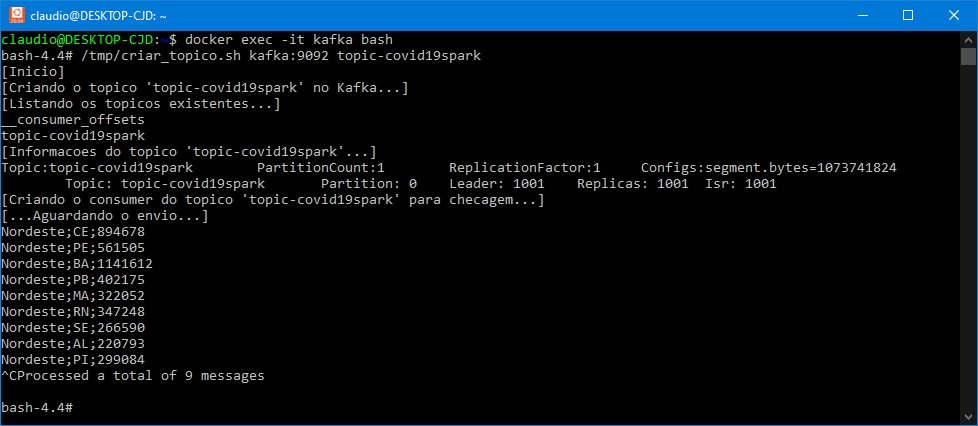

### g) (Kafka->Spark) Verificando o tópico com os dados gerados - lendo como batch:

In [18]:
%%time
df2 = spark.read\
           .format("kafka")\
           .option("kafka.bootstrap.servers","kafka:9092")\
           .option("subscribe","topic-covid19spark")\
           .load()

CPU times: user 3.49 ms, sys: 623 µs, total: 4.11 ms
Wall time: 7.63 ms


### g.1) Pegando a coluna formato csv e convertendo numa lista:

In [19]:
%%time
df2 = df2.select( col("value").cast("string"))
df2 = df2.select(split(col("value"),";").alias("colunasArray")).drop("value")
df2.show()

+--------------------+
|        colunasArray|
+--------------------+
|[Nordeste, CE, 89...|
|[Nordeste, PE, 56...|
|[Nordeste, BA, 11...|
|[Nordeste, PB, 40...|
|[Nordeste, MA, 32...|
|[Nordeste, RN, 34...|
|[Nordeste, SE, 26...|
|[Nordeste, AL, 22...|
|[Nordeste, PI, 29...|
+--------------------+

CPU times: user 0 ns, sys: 8.15 ms, total: 8.15 ms
Wall time: 234 ms


### g.2) Criando um Dataframe e exibindo os dados do tópico:

In [20]:
%%time
data = df2.select('colunasArray').rdd.flatMap(lambda x: x).collect()
df3 = spark.createDataFrame(data, ["regiao","estado","casosAcumulado"] )
df3.show(10,False)

+--------+------+--------------+
|regiao  |estado|casosAcumulado|
+--------+------+--------------+
|Nordeste|CE    |894678        |
|Nordeste|PE    |561505        |
|Nordeste|BA    |1141612       |
|Nordeste|PB    |402175        |
|Nordeste|MA    |322052        |
|Nordeste|RN    |347248        |
|Nordeste|SE    |266590        |
|Nordeste|AL    |220793        |
|Nordeste|PI    |299084        |
+--------+------+--------------+

CPU times: user 6.15 ms, sys: 11.4 ms, total: 17.5 ms
Wall time: 276 ms
